## Neural Network vs. Perceptron

### Load libraries

In [1]:
library(ggplot2) # for plot
library(reshape2) # for data manipulation

Load `train_nn.csv` and `test_nn.csv` sets, plot the training data with classes are marked with different colors, and attach the plot to your PDF report.

In [2]:
# auxillary functions
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
#   data <- data[sample(nrow(data),500),] # take 500 samples
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

In [3]:
# Read train and test datasets
set.seed(43) # set random seed

list[X1,T1] <- read.data('data/train_nn.csv') # read training data
list[X2,T2] <- read.data('data/test_nn.csv') # read test data

# convert 0 labels to -1
T1[T1==0] <- -1  
T2[T2==0] <- -1  

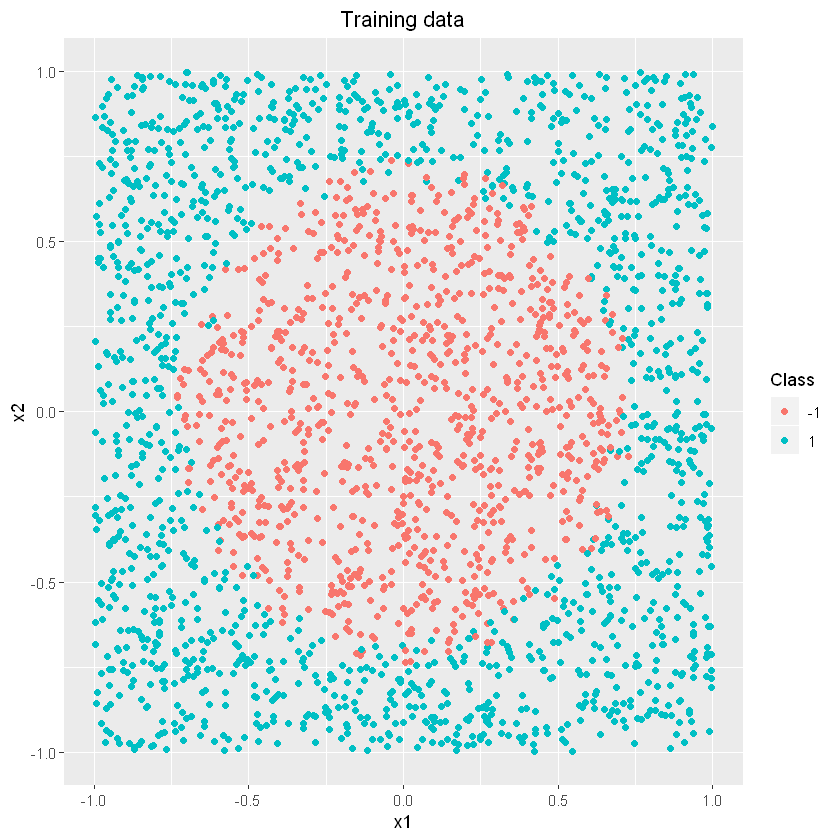

In [4]:
data <- cbind(X1, as.matrix(T1))

# rename column name
colnames(data)[3] <- "label"

# plot the data
ggplot(data=data, aes(x=x1, y=x2, color=factor(label))) + 
    geom_point() +
    scale_color_discrete(guide = guide_legend(title = "Class")) + 
    ggtitle ('Training data')+
    theme(plot.title = element_text(hjust = 0.5))

Train two perceptron models on the loaded training data by setting the learning rates η to .01 and .09 respectively.

Calculate the test errors of two models and find the best η and its corresponding model.

In [5]:
####################### PERCEPTRON #######################
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}

## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}

In [6]:
## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1        # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99   # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

Plot the test data while the points are colored with their estimated class labels using the best model

## $\eta=0.01$

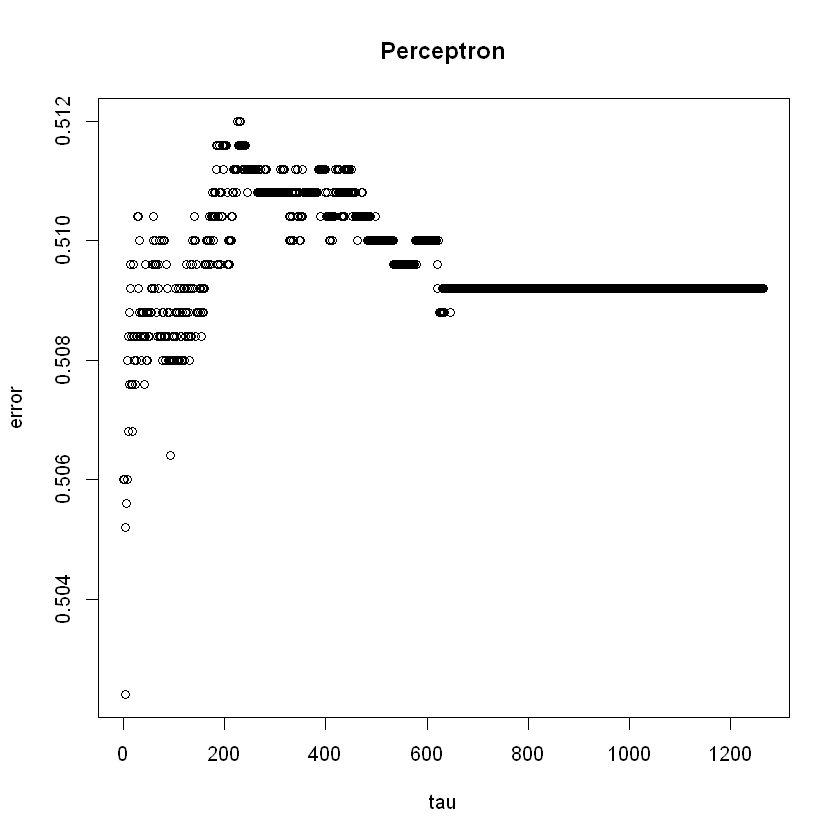

In [7]:
W1 <-perceptron.build(X2, T2,eta = 0.01, tau.max = nrow(X1), plotting = TRUE)

## $\eta=0.09$

[1]  6.334537e-13 -2.628280e-13 -8.623277e-13

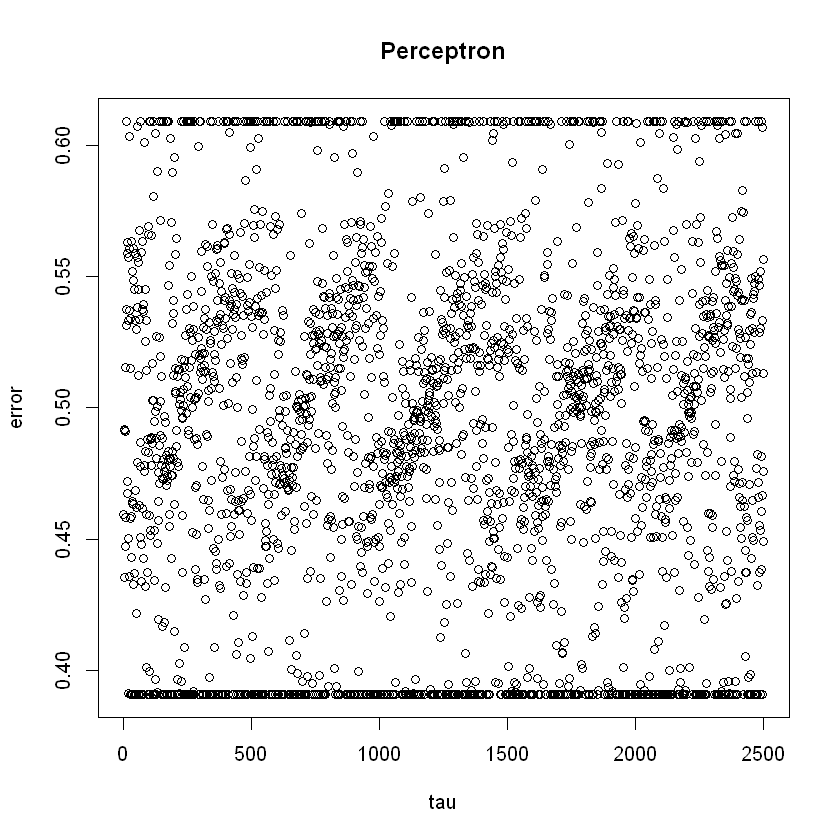

In [8]:
W9 <-perceptron.build(X2, T2,eta = 0.09, tau.max = nrow(X1), plotting = TRUE)
W9

To choose the better model out of above two, we will calculate error rate on test data

In [9]:
W1  <- as.matrix(W1)
W9  <- as.matrix(W9)

T2  <- as.matrix(T2)
N  <- nrow(X2)
test.Phi <- as.matrix(cbind(1, X2))

In [10]:
pred_1.score  <- test.Phi %*% W1
pred_1.label  <- ifelse(pred_1.score>0, 1, -1)
test_1.error <- sum(pred_1.label!=T2)/N
cat("Testing error rate for eta = 0.01 is: ", test_1.error, "\n")

pred_9.score  <- test.Phi %*% W9
pred_9.label  <- ifelse(pred_9.score>0, 1, -1)
test_9.error <- sum(pred_9.label!=T2)/N
cat("Testing error rate for eta = 0.09 is: ", test_9.error)

Testing error rate for eta = 0.01 is:  0.5092 
Testing error rate for eta = 0.09 is:  0.5132

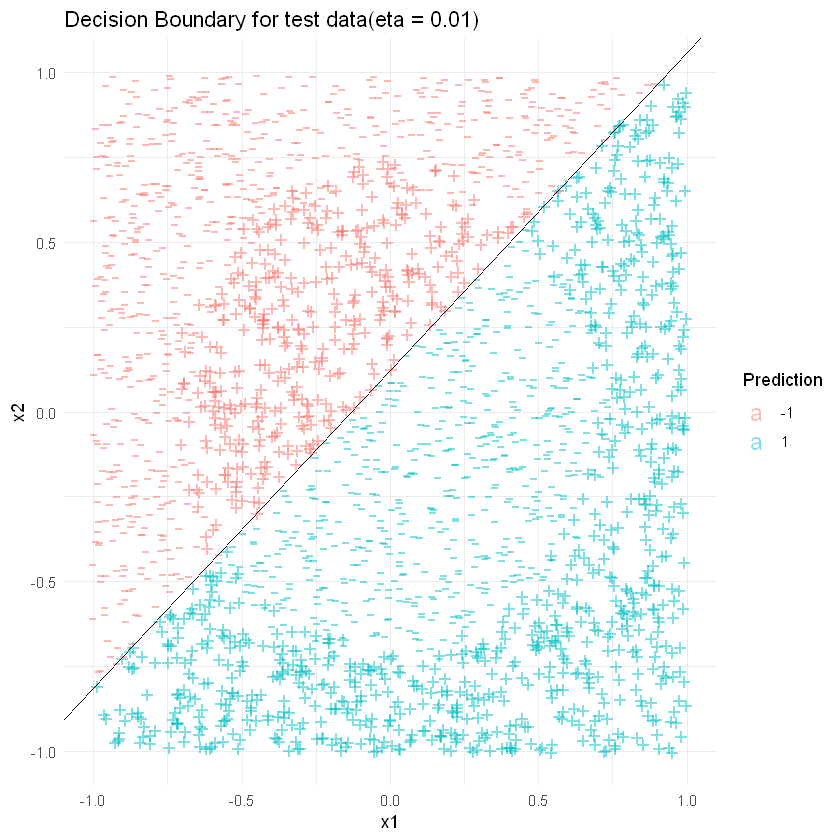

In [90]:
ggplot(data=X2,aes(x=x1, y=x2, color=factor(pred_1.label), label=ifelse(T2==pred_1.label, '+', '-'))) +
    geom_text(size = 5, alpha=0.5) +
    scale_color_discrete(guide = guide_legend(title = "Prediction")) + 
    geom_abline(intercept=-W1[1]/W1[3], slope=-W1[2]/W1[3]) +
    ggtitle ('Decision Boundary for test data(eta = 0.01)') + 
    theme_minimal()

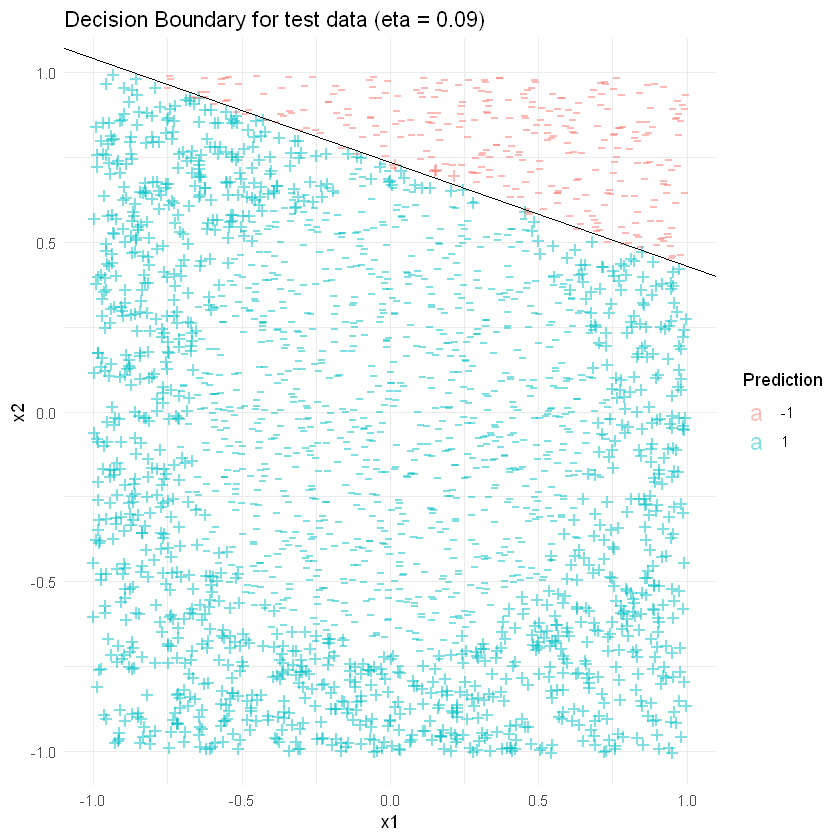

In [19]:
ggplot(data=X2,aes(x=x1, y=x2, color=factor(pred_9.label), label=ifelse(T2==pred_9.label, '+', '-'))) +
    geom_text(size = 5, alpha=0.5) +
    scale_color_discrete(guide = guide_legend(title = "Prediction")) + 
    geom_abline(intercept=-W9[1]/W9[3], slope=-W9[2]/W9[3]) +
    ggtitle ('Decision Boundary for test data (eta = 0.09)') + 
    theme_minimal()

We can see the plots for test results for learning rate 0.01 and 0.09. We can see that for this perceptron, results are better for learning rate = 0.01 which is evident from the test error as well. For larger value of learning rate, we see relatively poor performance. This is because for larger value of learning rate, here, the model has overshoot the minima. 

#### For each combination of K (i.e, number of units in the hidden layer) in {5, 10, 15, …, 100} and μ (learning rate) in {0.01, 0.09}, let's run the 3-layer Neural Network given and record testing error for each of them.

In [11]:
####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z) { 
  return ((exp(z)-exp(-z))/(exp(z)+exp(-z)))
}

## the derivitive of the activation function (tanh here)
h.d <- function(z) {
return (1-(h(z))^2)
}

## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}

In [12]:
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
#   plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  return(list(W1, W2, b1, b2))
}

In [13]:
# transpose X1 & X2
X1.t <- t(as.matrix(X1)) 
X2.t <- t(as.matrix(X2)) 

In [14]:
M  <- 100 # maximum neurons in a hidden layer

K <- seq(5, M, 5)
# create matrix for error tracking
error.trace  <- cbind(matrix(K, ncol = 1), 
                      matrix(0, nrow = length(K)), 
                      matrix(0, nrow = length(K)))
colnames(error.trace)  <- c("K", "error_01","error_09")

In [15]:
# create matrix to store predicted labels

# for learning rate 0.01
pred1.trace  <-  cbind(matrix(K, ncol = 1), 
                       matrix(0,nrow = length(K), ncol = length(T2)))

# for learning rate 0.09
pred9.trace  <-  cbind(matrix(K, ncol = 1), 
                       matrix(0,nrow = length(K), ncol = length(T2)))

### NN training for $\eta=0.01$

In [16]:
for (k in K) {
  # build model
  list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=TRUE, epoch.max=800, eta = 0.01, lambda = 0.03)
  nn.pred1  <- nn.predict(X2.t, W1, W2, b1, b2) # Get predictions from the model  
  pred1.trace[k/5, -1]  <- t(nn.pred1) # store predictions   
  err.test01  <- sum(t(nn.pred1)!=T2)/ncol(X2.t) # calculate errors
  error.trace[k/5,"error_01"]  <- err.test01
}

### NN training for $\eta=0.09$

In [17]:
for (k in K) {
  # build model
  list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=TRUE, epoch.max=800, eta = 0.09, lambda = 0.03)
  nn.pred9  <- nn.predict(X2.t, W1, W2, b1, b2) # Get predictions from the model  
  pred9.trace[k/5, -1]  <- t(nn.pred9) # store predictions   
  err.test09 <- sum(t(nn.pred9)!=T2)/ncol(X2.t) # calculate errors
  error.trace[k/5,"error_09"]  <- err.test09
}

In [83]:
error.trace

K,error_01,error_09
5,0.3908,0.2652
10,0.3908,0.1948
15,0.3908,0.1724
20,0.3908,0.1524
25,0.3708,0.1020
30,0.3524,0.0872
35,0.2768,0.0768
40,0.1716,0.0736
45,0.1476,0.1160
50,0.0840,0.1788


Plot the error for μ 0.01 and 0.09 vs K (one line for μ 0.01 and another line for μ 0.09 in a plot)

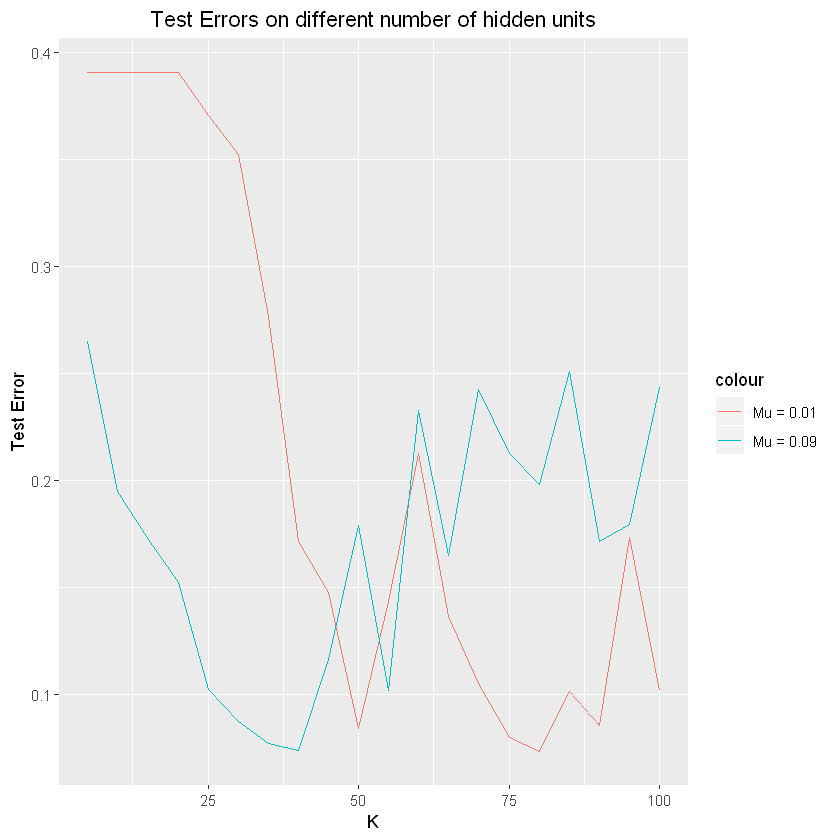

In [78]:
ggplot(data=as.data.frame(error.trace), aes(K)) + 
    geom_line(aes(y = error_01, colour = "Mu = 0.01"))  + 
    geom_line(aes(y = error_09, colour = "Mu = 0.09")) +
    ggtitle('Test Errors on different number of hidden units') + 
    ylab("Test Error") +
    theme(plot.title = element_text(hjust = 0.5))

In [91]:
cat("Minimum error for learning rate 0.01 is ", min(error.trace[,2]))
cat("\nMinimum error for learning rate 0.09 is ", min(error.trace[,3]))

Minimum error for learning rate 0.01 is  0.0732
Minimum error for learning rate 0.09 is  0.0736

In the above plot we can see that with the increase in number of hidden units, the test error decreases for learning rate = 0.01. After 50 hidden units are reached, the error rate remains almost constant (negligible decrease). Hence, we can say that model has reached local minima. For learning rate = 0.09 the test error decreases faster than what we saw with learning rate = 0.01. This is expected as the model converges faster for larger learning rate. But once the model reaches 50 units, its testing error increases which indicates the model is tending to overfit.

As minimum error for learning rate 0.01 is least among both above values, we will find corresponding K value 

In [92]:
# finding Corresponding K
error.trace[which(error.trace[,2]==min(error.trace[,2])),][1]

K 
80

In [29]:
# get prediction for best model
best.y.pred1 <- pred1.trace[which(error.trace[,1] == 80),]

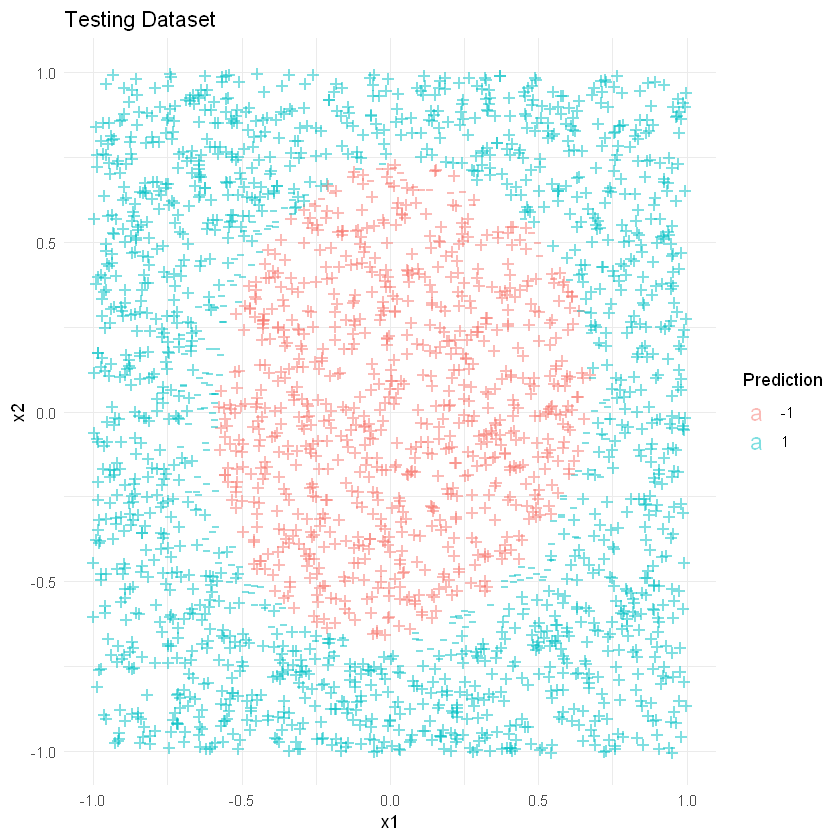

In [31]:
# plot
ggplot(data=X2,aes(x=x1, y=x2, color=factor(best.y.pred1[-1]), label=ifelse(T2==best.y.pred1[-1], '+', '-'))) +
    geom_text(size = 5, alpha=0.5) +
    scale_color_discrete(guide = guide_legend(title = "Prediction")) + 
    ggtitle ('Testing Dataset') + 
    theme_minimal()

Test result for best value of learning rate (0.01) and number of hidden units (K=80).

#### Reasons for this difference in results from Neural Networks and Perceptron

Perceptron is a single layered linear classifier with non-linear activation unit, on the other hand Neural network is non-linear model.

Although activation unit is non-linear in perceptron, the decision boundary remains linear. Her we have non-linear separation boundary between both the classes hence, perceptron is not able to identify the boundary correctly. So, we got the error rate of around 50-51%.

On the other hand, neural network is powerful enough to identify/classify data with non-linear separation. Based on this three-layered neural network architecture with enough neurons, the model is capable enough to identify this non-linear decision boundary and we are getting around 7% of test error. 

So, perceptron gives poor performance in both the cases of learning rate as perceptron is better suited for linearly separable data and here, we have non-linear data. Results from both these models can evident our claim as well.

